In [1]:
"""
Python script to scrape Friktion User Data from Bitquery GraphQL API.

"""

import json
import requests
import requests
import traceback
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from os.path import exists


class MyPortfolio:
    """
    Python ETL script for Friktion user portfolio data. Currently supported Instruction Names:
        - Deposit
        - CancelPendingDeposit
        - Withdrawal
        - CancelPendingWithdrawal
        - ClaimPendingWithdrawal
    """

    def __init__(
        self,
        date_start,
        date_end,
        ix_fname="./friktion_ix2.csv",
        deposit_fname="./friktion_deposit.csv",
        deposit_cxl_fname="./friktion_deposit_cxl.csv",
        withdraw_fname="./friktion_withdraw.csv",
        withdraw_cxl_fname="./friktion_withdraw_cancel.csv",
        withdraw_claim_fname="./friktion_claim_withdrawal.csv",
        endround_fname="./friktion_end_round4.csv",
        batch_size_days=3,
        batch_size_xfers=40,
        skip_ix_scrape=False
    ):
        """
        :ix_fname:              output csv for instructions
        :deposit_fname:         output csv for deposits
        :deposit_cxl_fname:     output csv for deposit cancels
        :withdraw_fname:        output csv for withdrawals
        :withdraw_cxl_fname:    output csv for withdrawal cancels
        :withdraw_claim_fname:  output csv for claiming pending withdrawal
        :batch_size_days:       batch size in days for query to keep query < 10k symbols. Use bigger steps for larger data.
        :batch_size_transfers:  batch size transactions for query to keep query < 8kb

        """
        print(date_start, date_end)
        self.volt_program = "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"
        self.date_start = date_start
        self.date_end = date_end
        self.ix_fname = ix_fname
        self.deposit_fname = deposit_fname
        self.deposit_cxl_fname = deposit_cxl_fname
        self.withdraw_fname = withdraw_fname
        self.withdraw_cxl_fname = withdraw_cxl_fname
        self.withdraw_claim_fname = withdraw_claim_fname
        self.end_round_fname = endround_fname
        self.batch_size_days = batch_size_days
        self.batch_size_xfers = batch_size_xfers
        self.skip_ix_scrape = skip_ix_scrape
        
        self.df_ix = pd.read_csv(ix_fname) if skip_ix_scrape else [] 
        print("print_ix", self.df_ix)
        self.friktion_metadata = self.get_friktion_snapshot()

    ########################################################################################################
    ####################################          Queries             ######################################
    ########################################################################################################

    @property
    def ix_query(self):
        return """
            query MyQuery {
              solana {
                instructions(
                  time: {between: ["%s", "%s"]}
                  success: {is: true}
                  programId: {is: "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"}
                  options: {limit: 8700}
                ) {
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  transaction {
                    signature
                    feePayer
                  }
                  data {
                    base58
                  }
                }
              }
            }
        """

    @property
    def xfer_query(self):
        return """
            query MyQuery {
              solana(network: solana) {
                transfers(
                  signature: {in: [%s]}
                  options: {limit: 2000}
                ) {
                  instruction {
                    action {
                      name
                    }
                    callPath
                  }
                  amount(success: {is: true})
                  transaction {
                    signer
                    signature
                  }
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  currency {
                    name
                    address
                  }
                  sender {
                    address
                    mintAccount
                  }
                  receiver {
                    address
                  }
                }
              }
            }
        """

    ########################################################################################################
    ################################          Helper Functions             #################################
    ########################################################################################################

    # TODO: Add retry logic to this in case of hangups.
    @staticmethod
    def run_query(query, retries=10):
        """
        Query graphQL API.

        If timeerror
        """
        headers = {"X-API-KEY": "BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4"}

        retries_counter = 0
        try:
            request = requests.post(
                "https://graphql.bitquery.io/", json={"query": query}, headers=headers
            )
            result = request.json()
            # print(dir(request.content))
            # Make sure that there is no error message
            # assert not request.content.errors
            assert "errors" not in result
        except:
            while (
                (request.status_code != 200
                or "errors" in result)
                and retries_counter < 10
            ):
                print(datetime.now(), f"Retry number {retries_counter}")
                if "errors" in result:
                    print(result["errors"])
                print(datetime.now(), f"Query failed for reason: {request.reason}. sleeping for {150*retries_counter} seconds and retrying...")
                time.sleep(150*retries_counter)
                request = requests.post(
                    "https://graphql.bitquery.io/",
                    json={"query": query},
                    headers=headers,
                )
                retries_counter += 1
            if retries_counter >= retries:
                raise Exception(
                    "Query failed after {} retries and return code is {}.{}".format(
                        retries_counter, request.status_code, query
                    )
                )
        return request.json()


    @staticmethod
    def batch_iterable(iterable, n=1):
        """
        Takes in an iterable and returns an iterable of iterables with len==x
        """
        idxs = []
        l = len(iterable)
        for idx in range(0, l, n):
            idxs.append(iterable[idx : min(idx + n, l)])
        return idxs

    def format_txs_for_query(self, tx_signatures):
        """
        Batches a list of transactions into a list of string formatted transactions for querying.
        Each of these strings contain (n=self.batch_size_xfers) unique transaction IDs.
        """
        batched_signatures = self.batch_iterable(tx_signatures, self.batch_size_xfers)

        def format_txs(x):
            return str(x)[1:-1].replace("'", '"').replace("\n", "")

        tx_strs = list(map(format_txs, batched_signatures))

        return tx_strs

    def get_existing_df(self, fname):
        """
        Create output file if doesn't exist and returns a DataFrame
        """
        if fname and exists(fname):
            return pd.read_csv(fname)
        else:
            return pd.DataFrame()

    @staticmethod
    def instruction_match(instructionData):
        """
        Match 8-bit instruction identifier with the corresonding instructionType
        """
        if not instructionData or len(instructionData) < 8:
            return False

        instructionDescriptor = instructionData[:8]

        if instructionDescriptor == "A4eeE44X" or instructionDescriptor == "7h4w9t5c" or instructionDescriptor == "K84hiiqe":
            print("EndRound: ", instructionDescriptor)
            return "EndRound"

    def get_friktion_snapshot(self):
        """
        Load Friktion Metadata for Volt/Symbol Mapping to join to normal data

        """
        try:
            return pd.DataFrame(
                dict(
                    json.loads(
                        requests.get(
                            "https://friktion-labs.github.io/mainnet-tvl-snapshots/friktionSnapshot.json"
                        ).content
                    )
                )["allMainnetVolts"]
            )[
                [
                    "globalId",
                    "vaultAuthority",
                    "shareTokenMint",
                    "depositTokenSymbol",
                    "depositTokenCoingeckoId",
                ]
            ]
        except Exception as e:
            print(datetime.now(), "Snapshot Data Invalid")
            traceback.print_exc()

    ########################################################################################################
    ################################          Data Retrieval             ###################################
    ########################################################################################################

    def get_ix(self, date_start, date_end):
        """
        Runs graphql instruction query for one date range.
        """
        print(date_start, date_end)
        query = self.ix_query % (date_start, date_end)
        print(
            datetime.now(),
            "retrieving instructions for {} to {}".format(date_start, date_end),
        )
        result = self.run_query(query)

        # convert GraphQL json to pandas dataframe
        try:
            df = pd.json_normalize(result["data"]["solana"]["instructions"])
        except:
            print(result)
            traceback.print_exc()
            raise Exception(datetime.now(), "Empty Results... Try Again")

        print(datetime.now(), df.shape[0], "instructions retrieved")

        df = df.rename(
            columns={
                "block.timestamp.iso8601": "timestamp",
                "log.consumed": "computeUnits",
                "transaction.signature": "txSignature",
                "transaction.feePayer": "txSigner",
                "data.base58": "instructionData",
            }
        )
        return df

    def get_ix_batch(self):
        """
        Batch the instruction retrieval. Save the shit Drop duplicates.

        """
        # Batch the days up nice and good so the graphql API calls don't bitch
        dates_batched = pd.date_range(self.date_start, self.date_end, freq=f"{self.batch_size_days}D")
        dates_batched = [
            str(x.isoformat())
            for x in dates_batched.append(pd.DatetimeIndex([self.date_end]))
        ]
        date_ranges = list(zip(dates_batched, dates_batched[1:]))
        ixs = []
        for date_range in date_ranges:
            assert len(date_range) == 2
            data = self.get_ix(date_range[0], date_range[1])
            ixs.append(data)

        df_ix = pd.concat(ixs, ignore_index=False)
        df_ix["instructionType"] = df_ix.instructionData.apply(
            lambda x: self.instruction_match(x)
        )

        # Store df_ix before we write it to the DataFrame so we avoid getting xfers for every single ix 
        self.df_ix = df_ix.drop_duplicates(["txSignature", "instructionType"]).reset_index(drop=True)
        print(datetime.now(), "final instruction data size: ", df_ix.shape[0])

        # Save new data to file
        df_old = self.get_existing_df(self.ix_fname)
        df = df_ix.append(df_old).reset_index(drop=True)
        df = df.drop_duplicates(["txSignature", "instructionType"])
        df.to_csv(self.ix_fname, index=False)
        print(datetime.now(), "wrote instruction data to csv...")

    def get_batched_xfers(self, instructionType, fname):
        """
        Get all transfers corresponding to a specific instructionType from Graphql query.
        Batch these queries up b/c the string size is
        too large (curse GraphQL for not supporting joins)

        :instructionType: String corresponding to the instruction type of each query.
        :fname: Name of where the old df is stored

        """

        temp = self.df_ix.query(f"instructionType == '{instructionType}'")

        if temp.empty:
            print(
                datetime.now(), "instructionType was not found in the data... breaking"
            )
            return

        tx_signatures = list(temp["txSignature"].unique())
        tx_strs = self.format_txs_for_query(tx_signatures)
        print(datetime.now(), len(tx_strs), "signature batches required...")
        xfers = []

        for i, tx_str in enumerate(tx_strs):
            query = self.xfer_query % (tx_str)
            result = self.run_query(query)
            # TODO: Clean up this duplicated logic
            try:
                df = pd.json_normalize(result["data"]["solana"]["transfers"])
            except:
                print(result)
                traceback.print_exc()
                raise Exception("Empty Results... Try Again")
            xfers.append(df)
            print(datetime.now(), df.shape[0], "transfers scraped in batch %d" % i)

        df_xfer = pd.concat(xfers, ignore_index=False)
        print("HELLO", df_xfer.loc[df_xfer["transaction.signature"] == "5b9HR69oQ61KBC5V5rsWr4kXh2PK3gEGhcqMvWyANvxvM9U2KPrxEXooPAoXo8HbeYndgZMJYcV4AJE38K33P5xy"])
        df_xfer = df_xfer.rename(
            columns={
                "block.timestamp.iso8601": "timestamp",
                "instruction.action.name": "instructionAction",
                "instruction.callPath": "instructionOrder",
                "transaction.signer": "userAddress",
                "transaction.signature": "txSignature",
                "currency.name": "currencyName",
                "receiver.address": "receiverAddress",
                "sender.address": "senderAddress",
                "currency.decimals": "currencyDecimals",
                "currency.address": "currencyAddress",
                "sender.mintAccount": "senderTokenMint",
            }
        )

        print(datetime.now(), df_xfer.shape[0], "transfers retrieved")

        return df_xfer
        
    def parse_endRound(self):
        instructionType = "EndRound"
        instructionAction = "transfer"
        tx_merge_key = "currencyAddress"
        meta_merge_key = "shareTokenMint"
        out_file = self.end_round_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )
        

    def parse_base(
        self,
        instructionType,
        instructionAction,
        tx_merge_key,
        meta_merge_key,
        output_file,
    ):
        """
        generalized method for parsing transfer data.

        1. Call get_batched_xfers()
        2. for each unique txSignature, find the xfer matching to the last instance of the instructionAction
        3. For SOL CC vaults, need an extra step and query for instructionAccount to find vaultAuthority.
        3. Join it to the friktion metadata based using tx_merge_key and meta_merge_key
        4. Drop extraneous rows
        5. Save the file to the output_file

        :instructionType: Type of instruction listed out in the instruction_match() method
        :instructionAction: type of transfer we are matching towards
        :tx_merge_key: what key in the xfer dataFrame do we want to merge on
        :output_file: as name suggests
        """
        print(
            datetime.now(),
            "Parsing transfers for instructionType: %s" % instructionType,
        )
        df = self.get_batched_xfers(instructionType, output_file)
#         Target only wrapped SOL entries for SOL vaults
        df = df.query('currencyName != "Solana"')
#         )
        shareTokendf = df.query("instructionAction=='mintTo'").copy()
        backup = df.query("instructionOrder=='0-0'").copy()
        # Backup-entropy
        backup_entropy = df.query("instructionOrder=='0-0-0'").copy()

    
        def find_matching_call_path(x, entropy=False):
            [path1, path2] = x.split("-")
            newCallPath = path1+"-"+str(int(path2)-1)
            if entropy:
                newCallPath=x
            return newCallPath
        
        shareTokendf["instructionOrderPair"] = shareTokendf.instructionOrder.apply(find_matching_call_path)
        shareTokendf["instructionOrderPair_Entropy"] = shareTokendf.instructionOrder.apply(find_matching_call_path, entropy=True)
        
        df_backup = df.copy()
        df = pd.merge(shareTokendf, df, left_on=["txSignature", "instructionOrderPair"], 
                      right_on=["txSignature", "instructionOrder"], suffixes=("", "_x"))
        
        df = pd.merge(backup, df, left_on=["txSignature"], 
                      right_on=["txSignature"], suffixes=("_y", ""), how='right')

        
        df["shareTokenPrice"] = df.amount_x/df.amount
        df["backupValue"] = df.amount_y
        # Join tables and get rid of extraneous columns from metadata.
        df = pd.merge(
            df,
            self.friktion_metadata,
            how="left",
            left_on=tx_merge_key,
            right_on=meta_merge_key,
            suffixes=("", "_drop"),
        )
        
        df.drop([col for col in df.columns if "drop" in col], axis=1, inplace=True)

        # Tag the row with the instructionType
        df["userAction"] = instructionType

        df.drop_duplicates().to_csv(output_file, index=False)
        print(datetime.now(), "{} data size: {}".format(instructionType, df.shape[0]))

    def parse_all(self):
        if not self.skip_ix_scrape:
            self.get_ix_batch()
        self.parse_endRound()


In [59]:
# date_start = "2021-12-10T00:00:00Z"
# date_start = "2021-12-01T00:00:00Z"
date_start = "2022-01-01T00:00:00Z"

date_end = "2022-07-09T09:00:00Z"

x = MyPortfolio(date_start, date_end, skip_ix_scrape=False)

x.parse_all()

# x.check_fidelity()

pd.set_option('display.max_rows', 500)


2022-01-01T00:00:00Z 2022-07-09T09:00:00Z
print_ix []
2022-01-01T00:00:00+00:00 2022-01-04T00:00:00+00:00
2022-07-07 13:32:19.477923 retrieving instructions for 2022-01-01T00:00:00+00:00 to 2022-01-04T00:00:00+00:00
2022-07-07 13:32:24.520043 1506 instructions retrieved
2022-01-04T00:00:00+00:00 2022-01-07T00:00:00+00:00
2022-07-07 13:32:24.521270 retrieving instructions for 2022-01-04T00:00:00+00:00 to 2022-01-07T00:00:00+00:00
2022-07-07 13:32:30.201109 1504 instructions retrieved
2022-01-07T00:00:00+00:00 2022-01-10T00:00:00+00:00
2022-07-07 13:32:30.201935 retrieving instructions for 2022-01-07T00:00:00+00:00 to 2022-01-10T00:00:00+00:00
2022-07-07 13:32:36.228375 2123 instructions retrieved
2022-01-10T00:00:00+00:00 2022-01-13T00:00:00+00:00
2022-07-07 13:32:36.229552 retrieving instructions for 2022-01-10T00:00:00+00:00 to 2022-01-13T00:00:00+00:00
2022-07-07 13:32:40.728054 1422 instructions retrieved
2022-01-13T00:00:00+00:00 2022-01-16T00:00:00+00:00
2022-07-07 13:32:40.728612

2022-07-07 13:35:35.794207 1590 instructions retrieved
2022-04-25T00:00:00+00:00 2022-04-28T00:00:00+00:00
2022-07-07 13:35:35.796364 retrieving instructions for 2022-04-25T00:00:00+00:00 to 2022-04-28T00:00:00+00:00
2022-07-07 13:35:38.562909 1025 instructions retrieved
2022-04-28T00:00:00+00:00 2022-05-01T00:00:00+00:00
2022-07-07 13:35:38.563979 retrieving instructions for 2022-04-28T00:00:00+00:00 to 2022-05-01T00:00:00+00:00
2022-07-07 13:35:43.060112 1952 instructions retrieved
2022-05-01T00:00:00+00:00 2022-05-04T00:00:00+00:00
2022-07-07 13:35:43.060927 retrieving instructions for 2022-05-01T00:00:00+00:00 to 2022-05-04T00:00:00+00:00
2022-07-07 13:35:45.811961 850 instructions retrieved
2022-05-04T00:00:00+00:00 2022-05-07T00:00:00+00:00
2022-07-07 13:35:45.812517 retrieving instructions for 2022-05-04T00:00:00+00:00 to 2022-05-07T00:00:00+00:00
2022-07-07 13:35:49.483859 2181 instructions retrieved
2022-05-07T00:00:00+00:00 2022-05-10T00:00:00+00:00
2022-07-07 13:35:49.485805

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_93475/933669419.py:338: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_ix.append(df_old).reset_index(drop=True)


2022-07-07 13:37:30.287334 wrote instruction data to csv...
2022-07-07 13:37:30.287433 Parsing transfers for instructionType: EndRound
2022-07-07 13:37:30.293226 13 signature batches required...
2022-07-07 13:37:32.356331 172 transfers scraped in batch 0
2022-07-07 13:37:34.268978 169 transfers scraped in batch 1
2022-07-07 13:37:36.226892 173 transfers scraped in batch 2
2022-07-07 13:37:38.262805 171 transfers scraped in batch 3
2022-07-07 13:37:40.415103 192 transfers scraped in batch 4
2022-07-07 13:37:42.303956 164 transfers scraped in batch 5
2022-07-07 13:37:44.073146 168 transfers scraped in batch 6
2022-07-07 13:37:46.372476 325 transfers scraped in batch 7
2022-07-07 13:37:48.630564 340 transfers scraped in batch 8
2022-07-07 13:37:50.821822 360 transfers scraped in batch 9
2022-07-07 13:37:54.312484 311 transfers scraped in batch 10
2022-07-07 13:37:56.486009 299 transfers scraped in batch 11
2022-07-07 13:37:58.179377 163 transfers scraped in batch 12
HELLO             amou

In [60]:
x = pd.read_csv("friktion_ix2.csv")

In [61]:
# x["descriptor"] = x.instructionData.apply(lambda x: x[:8])

# x.groupby("descriptor").count().sort_values("txSignature")[::-1]

# descriptor_mapping = {
#     "w8td1Pgp": "RebalanceEntropy",
#     "HRQyR9Nk": "RebalanceSpotEntropy",
#     "WuE7Hjns": "Deposit", 
#     "PcB3tF1K": "Withdraw",
#     "WcTWQsnk": "ClaimPendingWithdrawal",
#     "QWjEtL41": "RebalanceSwapPremium",
#     "9RXvtAW3": "SettlePermissionedMarketPremiumFunds", 
#     "YU8Ppoqd": "ClaimPending", 
#     "V8cW2nMq": "CancelPendingDeposit", 
#     "SnYUyKFV": "ChangeFees", 
#     "dxUbSCWk": "CancelPendingWithdrawal",
#     "9pv1k2a8": "SerumSettleFunds", 
#     "7h4w9t5c": "EndRound", 
#     "7a2PU2aM": "SetNextOption",
#     "RBSjdPDR": "StartRound", 
#     "WvyNQBKA": "RebalancePrepare",
#     "Lvp26pfj": "RebalanceSettle",
#     "33KksLfS": "InitSerumMarket",
#     "BPUqXCTy": "SettleSwapPremiumFunds",
#     "24gzsEwA": "RebalanceEnter",
#     "Voy7i3W9": "TakePendingWithdrawalFees",
#     "7hM6exz4": "ChangeCapacity",
#     "2xp1xTZY": "ChangeFees", 
#     "PsapmUHu": "SetupRebalanceEntropy",
#     "ACN3jH9F": "TakePerformanceFeesEntropy",
#     "PoTmZs3r": "StartRoundEntropy",
#     "K84hiiqe": "EndRoundEntropy",
#     "3QGfP6wm": "AttachWhitelist",
#     "3UpQt3a7": "TransferDeposit",
#     "ZXS1NcHZ": "ResetOptionMarket",
# }

In [62]:
#         ix = pd.read_csv("friktion_ix.csv")
#         deposits = pd.read_csv("friktion_deposit.csv")
#         withdrawals = pd.read_csv("friktion_withdraw.csv")
#         claim = pd.read_csv(self.withdraw_claim_fname)
#         withdrawals_cxl = pd.read_csv(self.withdraw_cxl_fname)
#         deposits_cxl = pd.read_csv(self.deposit_cxl_fname)
end_round = pd.read_csv('friktion_end_round4.csv')
end_round["timestamp_numba"] = pd.to_datetime(end_round.timestamp).astype('int')//1000000

In [63]:
end_round

,amount_y,instructionAction_y,instructionOrder_y,userAddress_y,txSignature,timestamp_y,currencyName_y,currencyAddress_y,senderAddress_y,senderTokenMint_y,...,receiverAddress_x,shareTokenPrice,backupValue,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction,timestamp_numba
0,4.558329e+03,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,3FRJ8fmZ8Z4F3LYHpTRgPfvMbwW2yk9bkGS7RbWHRiTaPp...,2022-01-07T09:07:21Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,FP7rhnmHexx2Tb4vbt7AX2PjEErSxFgnb8L2NwXwjT1D,...,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,1.000000,4.558329e+03,mainnet_income_put_mngo,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,CxHG1tPkeEHsAVmPF2UrjZK3W719J5DGFgMaLtUkBoeP,USDC,usd-coin,EndRound,1641546441000
1,4.574000e+01,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2Aczj26sBnAEJzoAwqW9ogrqwkhDWegpM8bRv7iyXv77hn...,2022-01-07T08:42:09Z,Wrapped SOL,So11111111111111111111111111111111111111112,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,unrWTSSfz6H7DzYYHRTuTCK3yVzR1YUNqUn7xWwr4Z5,...,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,1.037078,4.574000e+01,mainnet_income_call_sol,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,SOL,solana,EndRound,1641544929000
2,4.267000e+01,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2EiU6wGvD5XPpA5eikPjvfF584tc7t1KBzJuFxRX2QmTHA...,2022-01-14T08:56:25Z,Wrapped FTT (Sollet),AGFEad2et2ZJif9jaGpdMixQqvW5i81aBdvKe7PHNfz3,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,HcGvtMseBQTZVf9qrhkSW1zkiK8hUVnatybkeTfe3dJc,...,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,1.020679,4.267000e+01,mainnet_income_call_ftt,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,7wDh4VCTPwx41kvbLE6fkFgMEjnqw7NpGJvQtNabCm2B,FTT,ftx-token,EndRound,1642150585000
3,3.448620e+02,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2YH5kUZvcNbQt34GUqVXfnSnFtDz6bXzLv8UJsEWUaMXXm...,2022-01-21T08:31:22Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,Hzh5dx4K7BDYih4oQvBsgkhwe19TaNnTeyzBDpLJwU8D,...,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,1.006058,3.448620e+02,mainnet_income_put_btc,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,USDC,usd-coin,EndRound,1642753882000
4,4.281000e+01,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2b7baAZDYzxSiX29sabHrfqr11g75Ni4aKAcaYxRFHcBo7...,2022-01-21T08:59:12Z,Wrapped FTT (Sollet),AGFEad2et2ZJif9jaGpdMixQqvW5i81aBdvKe7PHNfz3,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,HcGvtMseBQTZVf9qrhkSW1zkiK8hUVnatybkeTfe3dJc,...,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,1.026961,4.281000e+01,mainnet_income_call_ftt,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,7wDh4VCTPwx41kvbLE6fkFgMEjnqw7NpGJvQtNabCm2B,FTT,ftx-token,EndRound,1642755552000
5,5.639183e+02,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,36PZp5jhDCjMK1TPoDo3pLGXTVSK4pi1fF23h7thQsJaHv...,2022-01-14T08:37:46Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,Hzh5dx4K7BDYih4oQvBsgkhwe19TaNnTeyzBDpLJwU8D,...,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,1.003288,5.639183e+02,mainnet_income_put_btc,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,USDC,usd-coin,EndRound,1642149466000
6,7.542000e+00,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,3DMUxQPzujEoSY1dAv3z2NNBBTAmrH7eoUQzwoUeYQPAeH...,2022-01-07T08:52:18Z,Socean staked SOL,5oVNBeEEQvYi1cX3ir8Dx5n1P7pdxydbGF2X4TxVusJm,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,7sp9EGacXqxNswsiS4hajmA7tXTjc8niBb7P1Gouq916,...,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,1.012661,7.542000e+00,mainnet_income_call_socean,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,5VmdHqvRMbXivuC34w4Hux9zb1y9moiBEQmXDrTR1kV,scnSOL,socean-staked-sol,EndRound,1641545538000
7,6.296500e+01,transfer,0-0,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,3HeS

In [64]:
791.963588/829.060158

0.9552546704336985

In [65]:
end_round.iloc[0]

amount_y                                                               4558.32892
instructionAction_y                                                      transfer
instructionOrder_y                                                            0-0
userAddress_y                        DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE
txSignature                     3FRJ8fmZ8Z4F3LYHpTRgPfvMbwW2yk9bkGS7RbWHRiTaPp...
timestamp_y                                                  2022-01-07T09:07:21Z
currencyName_y                                                           USD Coin
currencyAddress_y                    EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v
senderAddress_y                      CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6
senderTokenMint_y                    FP7rhnmHexx2Tb4vbt7AX2PjEErSxFgnb8L2NwXwjT1D
receiverAddress_y                    CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6
amount                                                              314551.587261
instructionActio

In [66]:
x = end_round[["timestamp_x", "timestamp_numba", "amount", "amount_x", "shareTokenPrice", "globalId", "vaultAuthority", "depositTokenSymbol", "txSignature"]]

x.columns=["Time", "EpochTime", "VoltTokens", "DepositTokens", "ShareTokenPrice", "GlobalID", "VaultAuthority", "DepositTokenSymbol", "Hash"]

In [67]:
x["ShareTokenPrice"] = x.ShareTokenPrice.fillna(0)

x = x.loc[~x.GlobalID.isna()]

x.to_csv("end_round.csv", index=False)

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_93475/4162894808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["ShareTokenPrice"] = x.ShareTokenPrice.fillna(0)


In [68]:
# TODO: add better logic here for share token price calculation

DEPOSIT_VALUES = {
    "mainnet_income_put_sol_step_circuits": [[1641033886000, 10000000]],
    "mainnet_income_put_btc_step_circuits": [[1641033886000, 2631100]],
    "mainnet_income_put_sol_uxd_circuits": [[1641033886000, 1000100]],
    "mainnet_income_put_sol_parrot_circuits": [[1641033886000, 1000000]],
}

end_round["cum_premium"] = end_round.sort_values("timestamp").groupby("globalId").backupValue.cumsum()

In [69]:
for idx, row in end_round.iterrows():
    if row["shareTokenPrice"] != row["shareTokenPrice"]:
        try:
            row["shareTokenPrice"] = 1+row["cum_premium"]*9/DEPOSIT_VALUES[row["globalId"]][0][1]
        except: 
            print(row.globalId, row.timestamp_numba)
    end_round.loc[idx] = row

nan 1642106598000
nan 1642144751000
nan 1643952440000
nan 1643955998000
mainnet_income_put_mngo 1648788992000
nan 1649920391000
nan 1649919466000
mainnet_income_put_pai 1652415480000
mainnet_income_call_sbr 1652417444000
mainnet_income_call_btc_step_circuits 1653536219000
mainnet_income_call_sbr 1653617990000
mainnet_income_call_btc_step_circuits 1654785288000
mainnet_income_call_sbr 1654830819000
mainnet_income_put_pai 1653632170000
mainnet_income_put_pai 1656042154000
mainnet_income_put_pai 1654832484000
mainnet_income_call_btc_step_circuits 1656042143000
mainnet_income_call_btc_step_circuits 1656647465000
mainnet_income_put_pai 1656647403000


In [70]:
OVERRIDES = [
    {
        "globalId": "mainnet_income_put_mngo", 
        "index": 9, 
        "operation": "insert", 
        "value": [1648788992000, 1.0472839410249204+0.0021]
    },
    {
        "globalId": "mainnet_income_call_luna", 
        "index": 15, 
        "operation": "replace", 
        "value": [1649994086000, 1.0312272300070189+0.0117]
    }
]

mainnet_income_put_mngo
[[1641546441000, 1.0], [1642151208000, 1.0020136200146303], [1642755812000, 1.003215555310568], [1643360834000, 0.9552546704336984], [1643963291000, 0.9593797187805956], [1644546234000, 1.0313042241641674], [1645150445000, 1.033445306318176], [1646362423000, 1.0400862254240566], [1647574042000, 1.0472839410249204], [1650062146000, 1.017333599811895], [1651267863000, 0.96135645878097], [1652419523000, 0.686404695400739], [1653619268000, 0.6901097976420334], [1654831234000, 0.6935589115206529], [1656042659000, 0.7009868441685146]]
[[1641546441000, 1.0], [1642151208000, 1.0020136200146303], [1642755812000, 1.003215555310568], [1643360834000, 0.9552546704336984], [1643963291000, 0.9593797187805956], [1644546234000, 1.0313042241641674], [1645150445000, 1.033445306318176], [1646362423000, 1.0400862254240566], [1647574042000, 1.0472839410249204], [1650062146000, 1.017333599811895], [1651267863000, 0.96135645878097], [1652419523000, 0.686404695400739], [1653619268000, 0

mainnet_income_put_sol
[[1641544839000, 1.0], [1642149009000, 1.0028133545000812], [1642753141000, 1.011834959827223], [1643359167000, 0.9307818107759028], [1643962370000, 0.9367077726733766], [1644566947000, 0.938135582311805], [1645171929000, 0.9403441396513889], [1645755471000, 0.9443159427383588], [1646361019000, 0.9484223993104272], [1646965581000, 0.9519769138517704], [1647570032000, 0.9578401604220684], [1648177215000, 0.9626341435053308], [1648787900000, 0.9668458347679516], [1649385638000, 0.9725567141635356], [1649991892000, 0.975628998911918], [1650602035000, 0.978232806838076], [1651207756000, 0.9820697615440832], [1651807782000, 0.9869182450305156], [1652412410000, 0.6792245550732805], [1653021156000, 0.682498031273928], [1653617760000, 0.6851586572193875], [1654206295000, 0.6901181153746194], [1654831234000, 0.6941857221923462], [1656042659000, 0.7056679317216382], [1656647406000, 0.7104291534509588]]
[[1641544839000, 1.0], [1642149009000, 1.0028133545000812], [1642753141

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_93475/2974650420.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


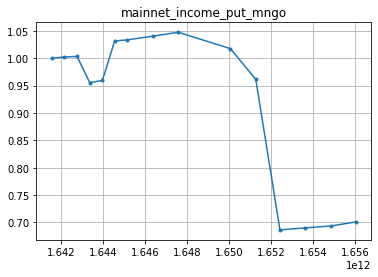

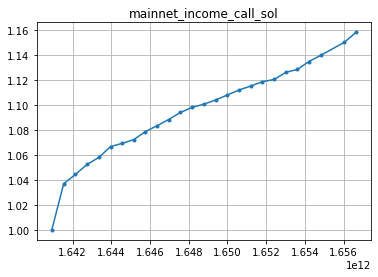

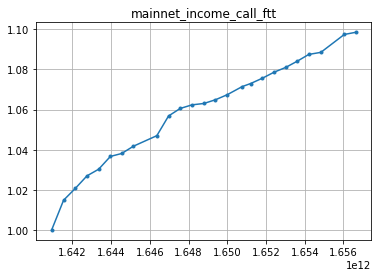

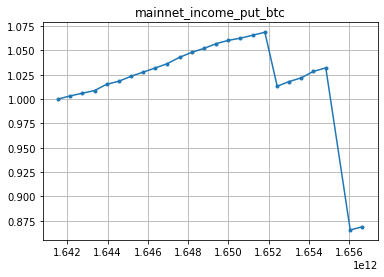

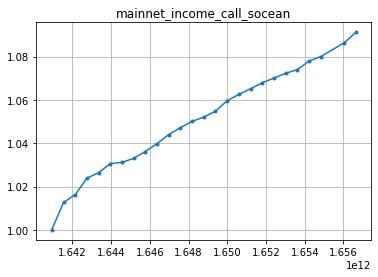

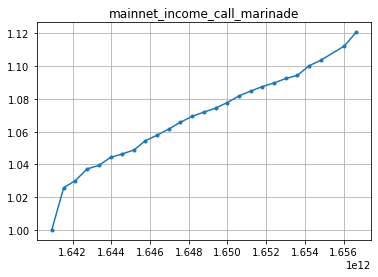

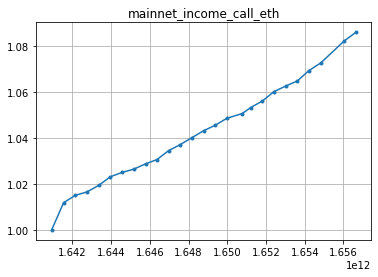

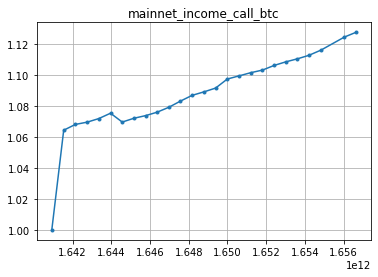

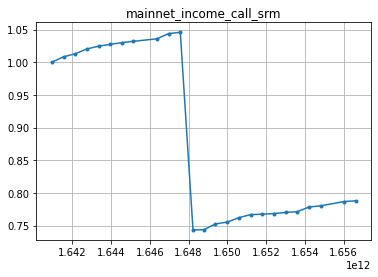

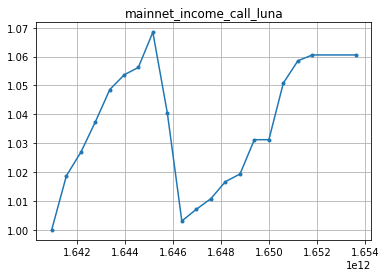

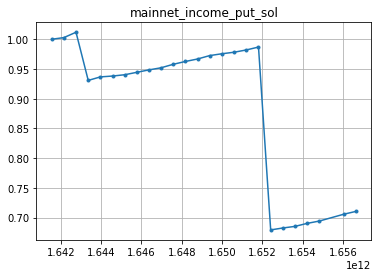

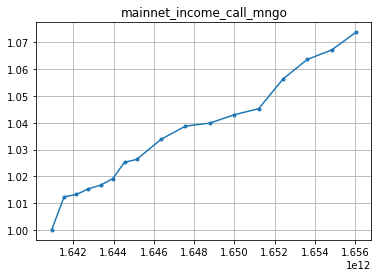

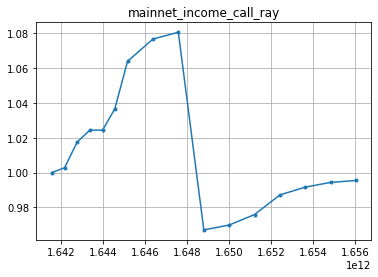

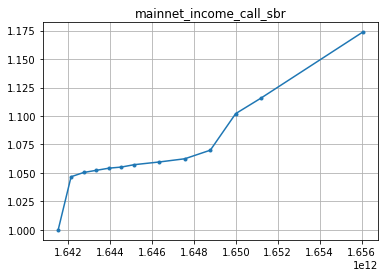

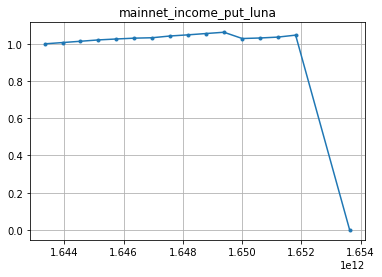

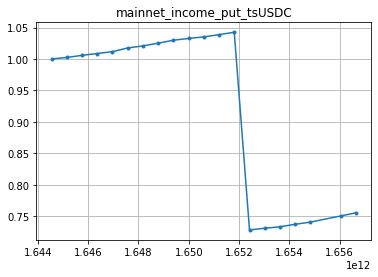

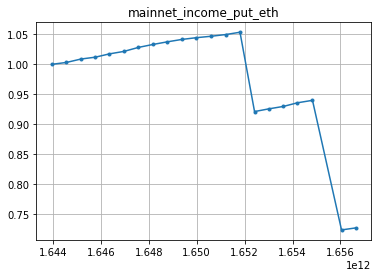

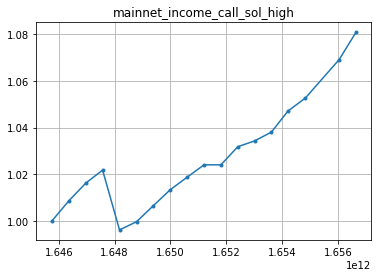

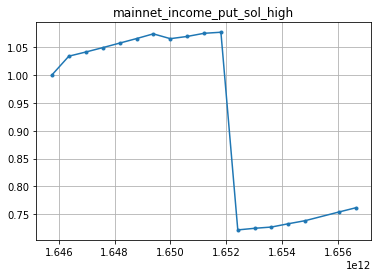

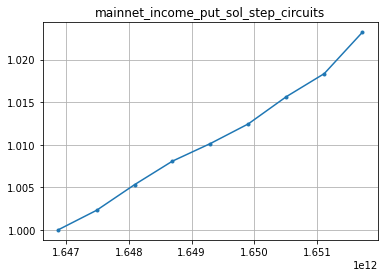

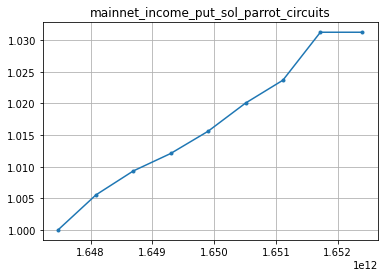

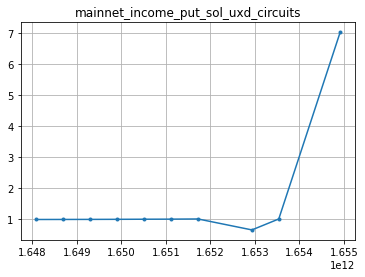

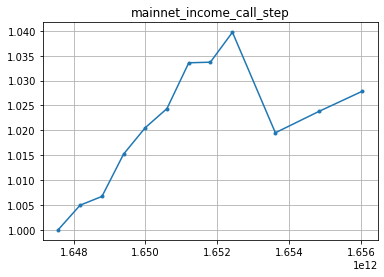

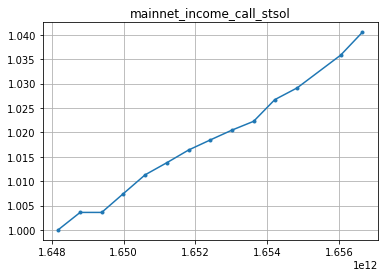

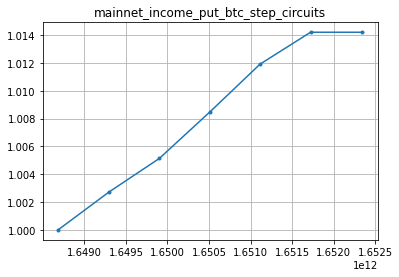

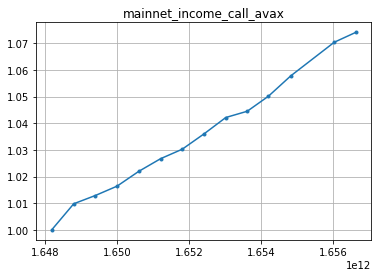

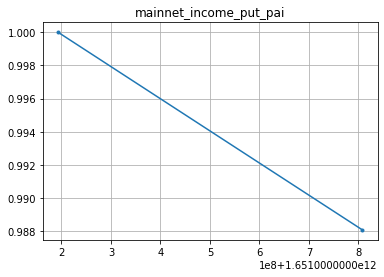

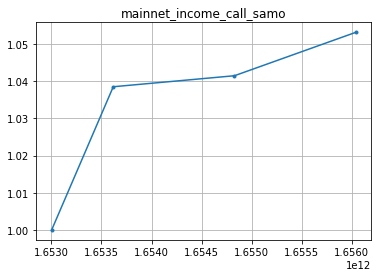

In [71]:
for globalId in end_round.globalId.unique():
    print(globalId)
    if globalId!=globalId:
        continue
    temp = end_round.query("globalId == @globalId").copy().sort_values("timestamp")
    output = temp[["timestamp_numba", "shareTokenPrice"]].values.tolist()
    output =  list(filter(lambda x: x, map(lambda x: [int(x[0]), x[1]] if x[1]==x[1] else None, output)))
    print(output)
    if not output:
        continue
    if output[0][1] < 0.999999 or output[0][1] > 1.0000001:
        output.insert(0, [output[0][0]-61*60*24*7*1000, 1.0])
    
#     for override in OVERRIDES:
#         if globalId == override["globalId"]:
#             if override["operation"]=="insert":
#                 print(f"Inserted: {override['value']}")
#                 output.insert(override["index"], override["value"])
#             elif override["operation"]=="replace":
#                 print(f"Replaced: {override['index']}")
#                 output[override["index"]] = override["value"]
                
    print(output)
    plt.figure()
    plt.plot([x[0] for x in output], [x[1] for x in output], marker='.')
    plt.title(globalId)
    plt.grid(True)

#     with open(f'../derived_timeseries/{globalId}_sharePricesByGlobalId.json', 'w') as f:
#         json.dump(output, f, separators=(",", ":"), indent=2)

In [72]:
end_round["timestamp"] = pd.to_datetime(end_round.timestamp_numba, unit='ms')

In [73]:
end_round[["timestamp", "globalId", "shareTokenPrice", "amount_x", "amount_y"]].sort_values("amount_y")

,timestamp,globalId,shareTokenPrice,amount_x,amount_y
326,2022-05-13 00:21:08,mainnet_income_put_sol_parrot_circuits,1.031258,0.000000e+00,0.000000e+00
325,2022-05-13 04:18:00,mainnet_income_put_pai,NaN,0.000000e+00,0.000000e+00
468,2022-07-01 03:45:32,mainnet_income_call_stsol,1.040508,5.761488e+00,0.000000e+00
328,2022-05-12 09:14:56,mainnet_income_put_btc_step_circuits,1.014207,0.000000e+00,0.000000e+00
467,2022-07-01 03:51:05,mainnet_income_call_btc_step_circuits,NaN,0.000000e+00,0.000000e+00
477,2022-07-01 03:50:03,mainnet_income_put_pai,NaN,0.000000e+00,0.000000e+00
362,2022-05-26 03:36:59,mainnet_income_call_btc_step_circuits,NaN,0.000000e+00,0.000000e+00
40,2022-02-04 05:27:20,NaN,NaN,0.000000e+00,0.000000e+00
360,2022-05-26 03:28:01,mainnet_income_put_sol_uxd_circuits,1.017012,0.000000e+00,0.000000e+00
434,2022-06-24 03:42:34,mainnet_income_put_pai,NaN,0.000000e+00,0.000000e+00


In [74]:
end_round.globalId.unique()

array(['mainnet_income_put_mngo', 'mainnet_income_call_sol',
       'mainnet_income_call_ftt', 'mainnet_income_put_btc',
       'mainnet_income_call_socean', 'mainnet_income_call_marinade',
       'mainnet_income_call_eth', 'mainnet_income_call_btc',
       'mainnet_income_call_srm', 'mainnet_income_call_luna',
       'mainnet_income_put_sol', 'mainnet_income_call_mngo', nan,
       'mainnet_income_call_ray', 'mainnet_income_call_sbr',
       'mainnet_income_put_luna', 'mainnet_income_put_tsUSDC',
       'mainnet_income_put_eth', 'mainnet_income_call_sol_high',
       'mainnet_income_put_sol_high',
       'mainnet_income_put_sol_step_circuits',
       'mainnet_income_put_sol_parrot_circuits',
       'mainnet_income_put_sol_uxd_circuits', 'mainnet_income_call_step',
       'mainnet_income_call_stsol',
       'mainnet_income_put_btc_step_circuits', 'mainnet_income_call_avax',
       'mainnet_income_put_pai', 'mainnet_income_call_btc_step_circuits',
       'mainnet_income_call_samo'], dty

In [75]:
end_round.columns

Index(['amount_y', 'instructionAction_y', 'instructionOrder_y',
       'userAddress_y', 'txSignature', 'timestamp_y', 'currencyName_y',
       'currencyAddress_y', 'senderAddress_y', 'senderTokenMint_y',
       'receiverAddress_y', 'amount', 'instructionAction', 'instructionOrder',
       'userAddress', 'timestamp', 'currencyName', 'currencyAddress',
       'senderAddress', 'senderTokenMint', 'receiverAddress',
       'instructionOrderPair', 'instructionOrderPair_Entropy', 'amount_x',
       'instructionAction_x', 'instructionOrder_x', 'userAddress_x',
       'timestamp_x', 'currencyName_x', 'currencyAddress_x', 'senderAddress_x',
       'senderTokenMint_x', 'receiverAddress_x', 'shareTokenPrice',
       'backupValue', 'globalId', 'vaultAuthority', 'shareTokenMint',
       'depositTokenSymbol', 'depositTokenCoingeckoId', 'userAction',
       'timestamp_numba', 'cum_premium'],
      dtype='object')

mainnet_income_call_ray
[[1641536545000, 1.0], [1642151425000, 1.002748758055082], [1642756227000, 1.0176369145942914], [1643357278000, 1.0243848923792762], [1643963691000, 1.024385187838707], [1644545693000, 1.0366130102559703], [1645151633000, 1.0638966931848464], [1646362510000, 1.0766823189002608], [1647572570000, 1.0806019020086295], [1648788830000, 0.9670753967427048], [1649995848000, 0.96987074262163], [1651206084000, 0.9759088996876216], [1652417564000, 0.9871924779371716], [1653617990000, 0.9916312777240464], [1654830823000, 0.9943542822257494], [1656042186000, 0.995471948589612], [1648788830000, 0.9670753967427048]]
[[1641536545000, 1.0], [1642151425000, 1.002748758055082], [1642756227000, 1.0176369145942914], [1643357278000, 1.0243848923792762], [1643963691000, 1.024385187838707], [1644545693000, 1.0366130102559703], [1645151633000, 1.0638966931848464], [1646362510000, 1.0766823189002608], [1647572570000, 1.0806019020086295], [1648788830000, 0.9670753967427048], [16499958480

[[1648173295000, 1.0], [1648788175000, 1.0035869942774749], [1649389462000, 1.003586994278105], [1649993402000, 1.0074434950072169], [1650597326000, 1.0112877199734254], [1651207673000, 1.01379593960379], [1651807786000, 1.016372946024892], [1652417150000, 1.0184558024598926], [1653021156000, 1.020471685384818], [1653618033000, 1.0222526643352756], [1654207981000, 1.026697701560073], [1654830815000, 1.0291068765099112], [1654830815000, 1.0291068765099112], [1654830815000, 1.0291068765099112], [1655435691000, 1.0334353540714871], [1656042189000, 1.0358171269286665], [1656647132000, 1.0405081613828158], [1648788175000, 1.0035869942774749]]
mainnet_income_call_mngo
[[1640929126000, 1.0], [1641544006000, 1.0123246963671988], [1642150948000, 1.013221271053866], [1642755804000, 1.0153261314527335], [1643360769000, 1.0167063610684668], [1643963157000, 1.0191517845117302], [1644545905000, 1.0252250251334256], [1645150341000, 1.0262978310037372], [1646362318000, 1.0337966416134052], [1647574024

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_93475/1886912790.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


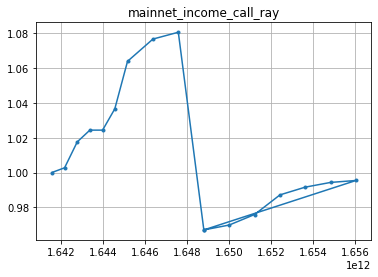

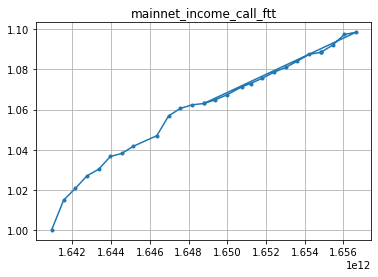

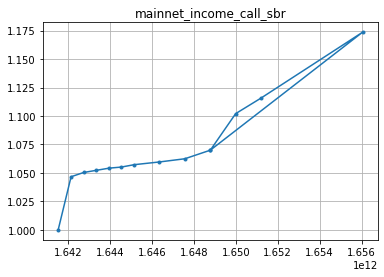

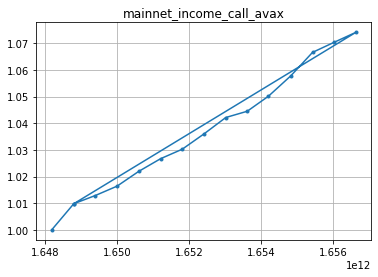

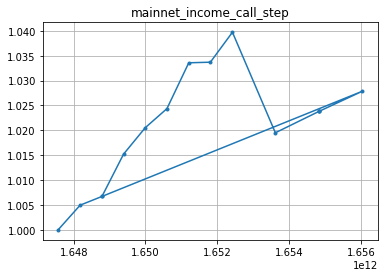

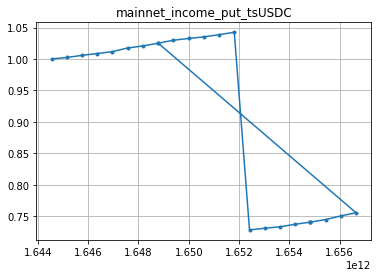

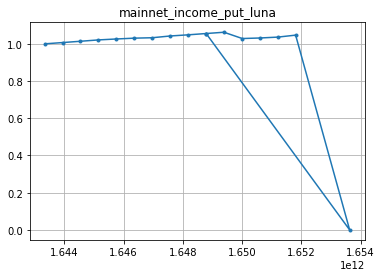

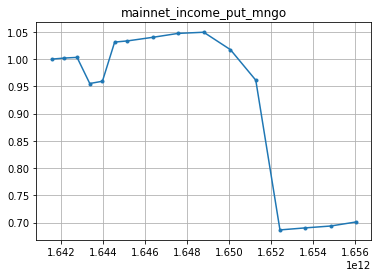

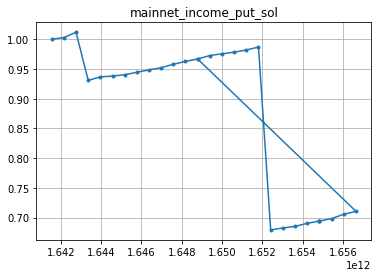

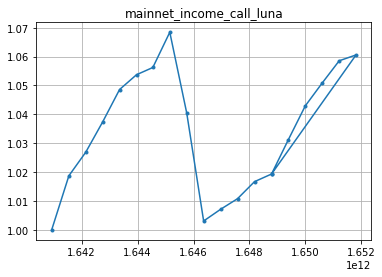

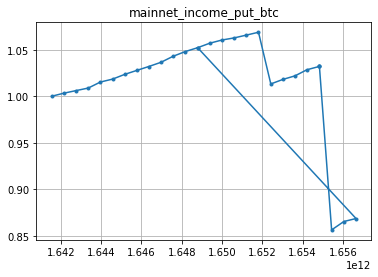

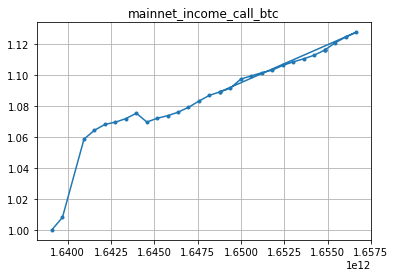

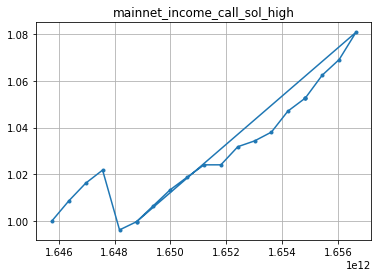

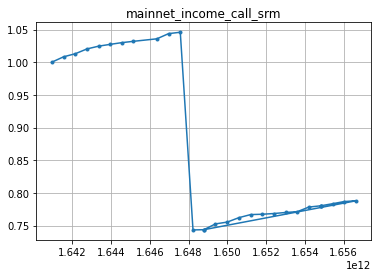

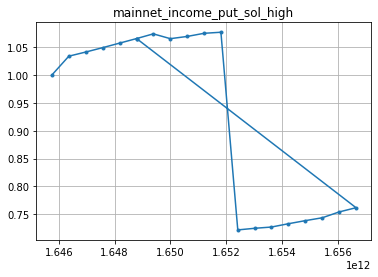

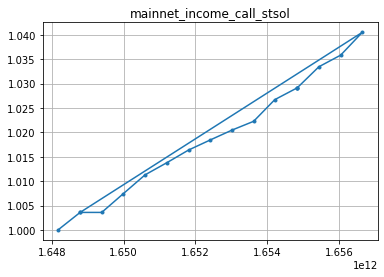

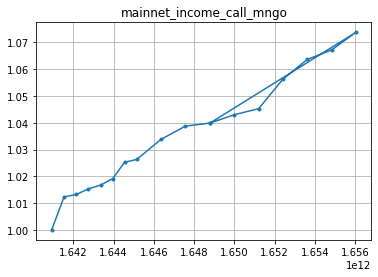

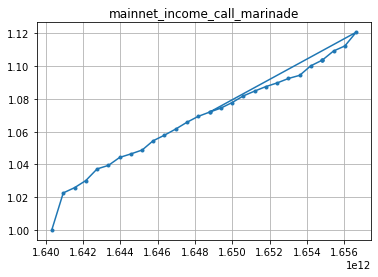

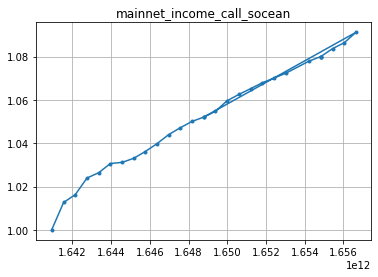

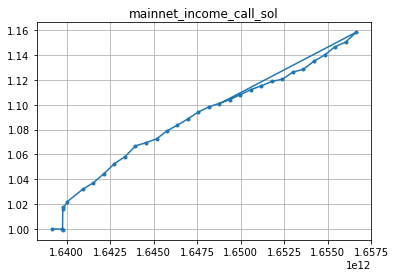

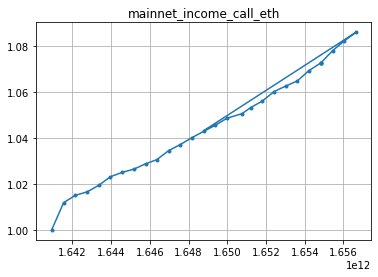

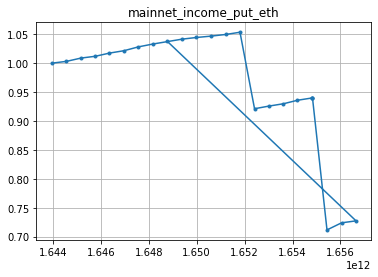

In [16]:
for globalId in end_round.globalId.unique():
    print(globalId)
    # Circuits override
    if globalId!=globalId or "circuits" in globalId or "pai" in globalId:
        continue
    temp = end_round.query("globalId == @globalId").copy().sort_values("timestamp")
    output = temp[["timestamp_numba", "shareTokenPrice"]].values.tolist()
    output =  list(filter(lambda x: x, map(lambda x: [int(x[0]), x[1]] if x[1]==x[1] else None, output)))
#     if output[0][1] < 0.999999 or output[0][1] > 1.0000001:
#         output.insert(0, [output[0][0]-61*60*24*7*1000, 1.0])
    
#     for override in OVERRIDES:
#         if globalId == override["globalId"]:
#             if override["operation"]=="insert":
#                 print(f"Inserted: {override['value']}")
#                 output.insert(override["index"], override["value"])
#             elif override["operation"]=="replace":
#                 print(f"Replaced: {override['index']}")
#                 output[override["index"]] = override["value"]


    wdata = []
    with open(f'../derived_timeseries/{globalId}_sharePricesByGlobalId.json', 'r') as f:
        try:
            existing = json.load(f)
            if output and output[0] not in [x[0] for x in existing]:
                existing.extend(output)
            else:
                print("already exists")
        except: 
            existing = []
        wdata = existing
    
    print(wdata)
    plt.figure()
    plt.plot([x[0] for x in existing], [x[1] for x in existing], marker='.')
    plt.title(globalId)
    plt.grid(True)

    

        
    print(wdata)
    
#     with open(f'../derived_timeseries/{globalId}_sharePricesByGlobalId.json', 'w') as f:
#         json.dump(wdata, f, separators=(",", ":"), indent=2)

In [ ]:
for globalId in end_round.globalId.unique():
    plt.figure()
    temp = end_round.query("globalId == @globalId").copy()
    temp["timestamp"] = pd.to_datetime(temp.timestamp)
    temp.set_index("timestamp").shareTokenPrice.plot(title=globalId, marker='.')
    plt.grid(True)

In [159]:
temp.txSignature.iloc[0]

'yBaqAuPZpa1ma8T6YsuiRL4qvnEHuwxWMmzpWcdPzRERjHetDzfNmdew6qLWWx6RF8cxSG8V3J9KWtVqwQWxVDM'

In [22]:
import requests

In [27]:
x = json.loads(requests.get("https://stats.entropy.trade/token_portfolio?userAddress=H6S9znd4mWtz3ug5wMt4yAzekKscbCfYkskCrc6y8uRr").content)

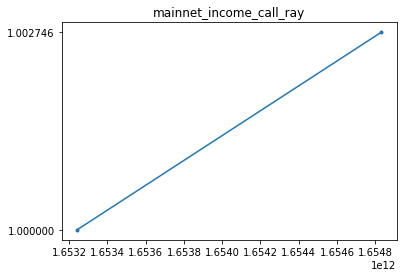

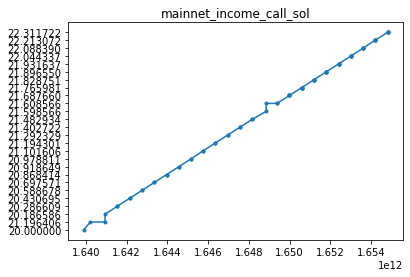

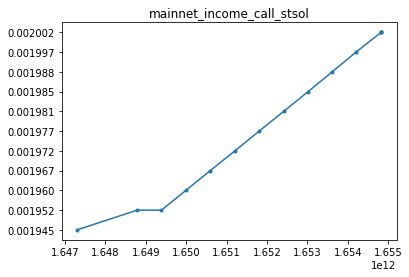

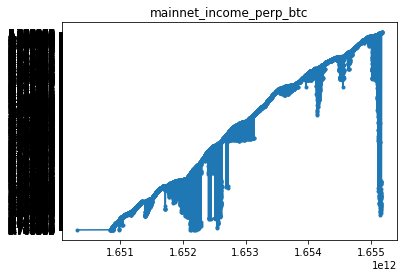

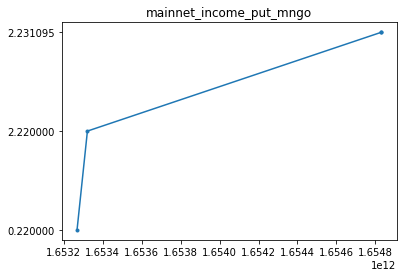

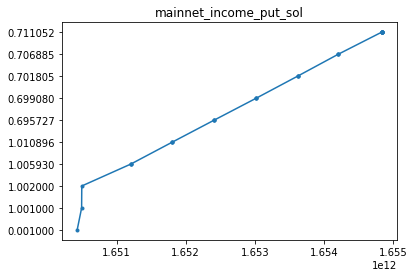

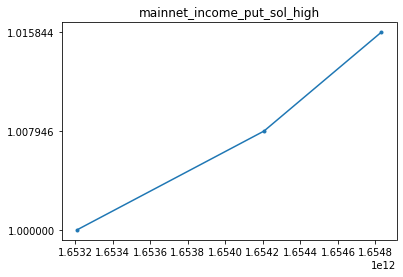

In [39]:
for y in x.keys():
    plt.figure()
    z = pd.DataFrame(x[y])
#     print(z)
    plt.plot(z[0], z[1], marker='.')
    plt.title(y)

In [ ]:
z = pd.read_csv("pliny.csv")

z

z["unifedTime"] = pd.to_datetime(z.unifedTime)

<AxesSubplot:title={'center':'Position Value SOL Call'}, xlabel='unifedTime'>

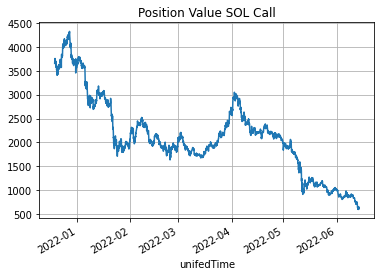

In [51]:
z.set_index("unifedTime").USDCPosition.plot(grid=True, title="Position Value SOL Call")

<AxesSubplot:title={'center':'Premium Earned Every Week marked to spot price at time of epoch'}, xlabel='unifedTime'>

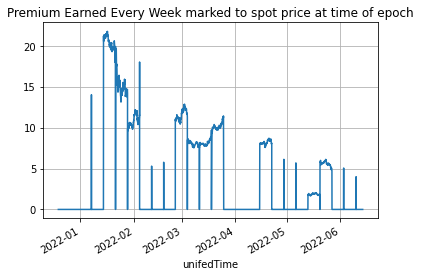

In [52]:
z.set_index("unifedTime").USDCPNL.plot(grid=True, title="Premium Earned Every Week marked to spot price at time of epoch")

In [60]:
z["week"] = z.unifedTime.dt.week

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_56822/2837112976.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  z["week"] = z.unifedTime.dt.week


<AxesSubplot:xlabel='week'>

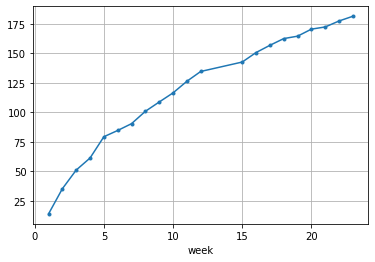

In [67]:
z.loc[z.USDCPNL>0].groupby("week").USDCPNL.last().cumsum().plot(grid=True, marker='.')

<AxesSubplot:xlabel='week'>

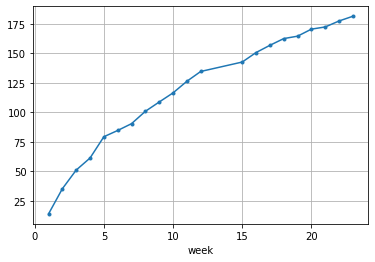

In [67]:
z.loc[z.USDCPNL>0].groupby("week").USDCPNL.last().cumsum().plot(grid=True, marker='.')

<AxesSubplot:xlabel='week'>

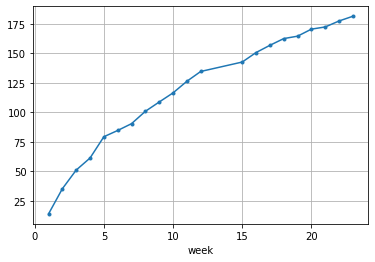

In [67]:
z.loc[z.USDCPNL>0].groupby("week").USDCPNL.last().cumsum().plot(grid=True, marker='.')

<AxesSubplot:title={'center':'Premium Earned Every Week marked to spot price at time of epoch'}, xlabel='unifedTime'>

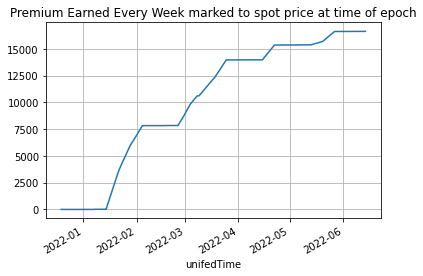

In [54]:
z.set_index("unifedTime").USDCPNL.cumsum().plot(grid=True, title="Premium Earned Every Week marked to spot price at time of epoch")

<AxesSubplot:title={'center':'Cumulative PNL MTM'}, xlabel='unifedTime'>

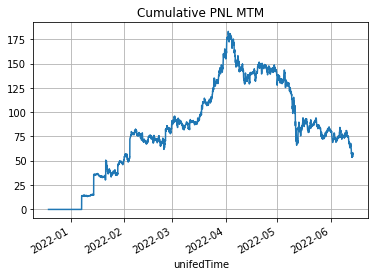

In [53]:
z.set_index("unifedTime").USDCPNLCumulative.plot(grid=True, title="Cumulative PNL MTM")

In [69]:
z["SOL"] = 20 * z["spotPropagated"]

<AxesSubplot:title={'center':'Cumulative PNL MTM'}, xlabel='unifedTime'>

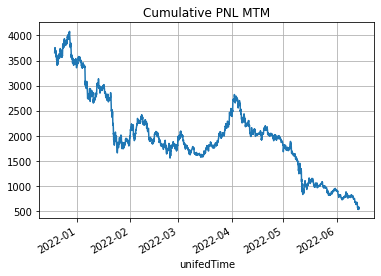

In [70]:
z.set_index("unifedTime").SOL.plot(grid=True, title="Cumulative PNL MTM")

In [71]:
z["TOTAL"] = z.SOL + z.USDCPNLCumulative

<AxesSubplot:title={'center':'Cumulative PNL MTM'}, xlabel='unifedTime'>

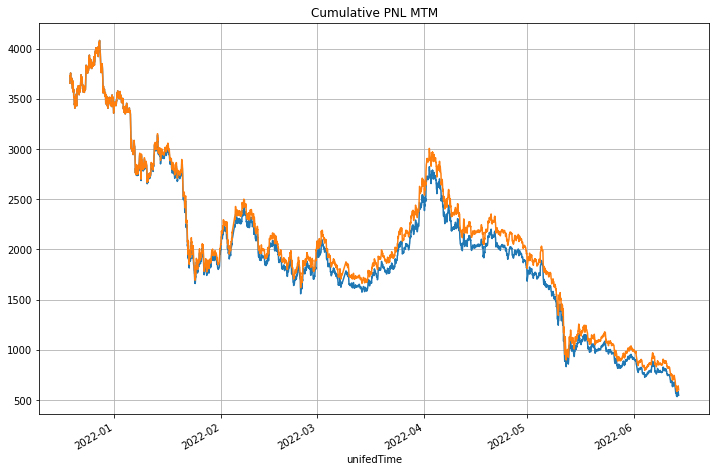

In [73]:
plt.figure(figsize=(12, 8))

z.set_index("unifedTime").SOL.plot(grid=True, title="Cumulative PNL MTM")
z.set_index("unifedTime").TOTAL.plot(grid=True, title="Cumulative PNL MTM")

In [71]:
z["TOTAL"] = z.SOL + z.USDCPNLCumulative

<AxesSubplot:title={'center':'Cumulative PNL MTM'}, xlabel='unifedTime'>

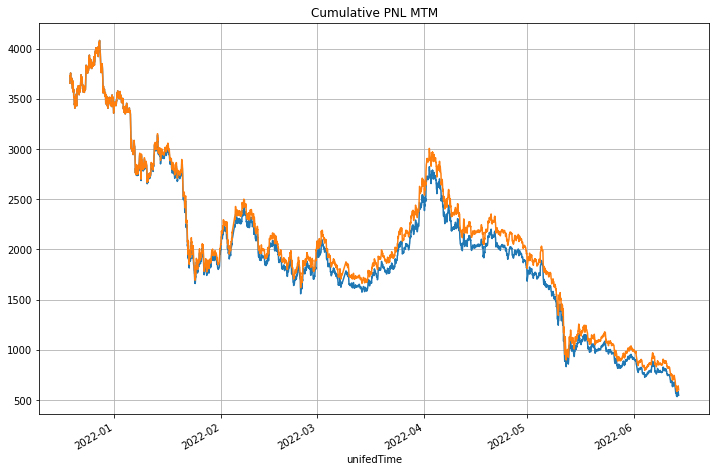

In [73]:
plt.figure(figsize=(12, 8))

z.set_index("unifedTime").SOL.plot(grid=True, title="Cumulative PNL MTM")
z.set_index("unifedTime").TOTAL.plot(grid=True, title="Cumulative PNL MTM")

In [76]:
z["pct"] =z.TOTAL/z.SOL

<AxesSubplot:title={'center':'Percentage '}, xlabel='unifedTime'>

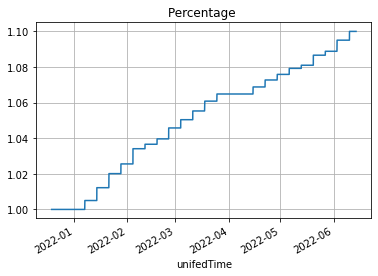

In [79]:
z.set_index("unifedTime").pct.plot(grid=True, title="Percentage ")

In [68]:
z.columns

Index(['GlobalID', 'DepositTokenSymbol', 'Timestamp', 'sharePrice',
       'UserAction', 'UserAddress', 'epochTime', 'Hash', 'Amount',
       'UserActionFlag', 'EpochActionFlag', 'Tokens', 'activeTime',
       'ShareTokenPosition', 'TokenPosition', 'TokenPNL', 'TokenPNLCumulative',
       'spotPrice', 'time', 'GlobalID-2', 'unifedTime', 'spotPropagated',
       'TokenPositionPropagated', 'TokenPNLPropagated',
       'TokenPNLCumulativePropagated', 'USDCPosition', 'USDCPNL',
       'USDCPNLCumulative', 'week'],
      dtype='object')

In [82]:
z = pd.read_csv("plinuy2.csv")

z

z["unifedTime"] = pd.to_datetime(z.unifedTime)

In [85]:
z.USDPNLCumulAlpha

0        0.0
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
13862    NaN
13863    NaN
13864    NaN
13865    NaN
13866    NaN
Name: USDPNLCumulAlpha, Length: 13867, dtype: float64

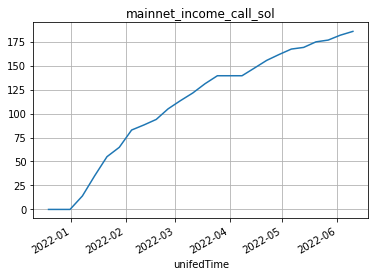

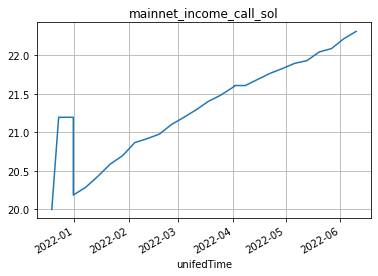

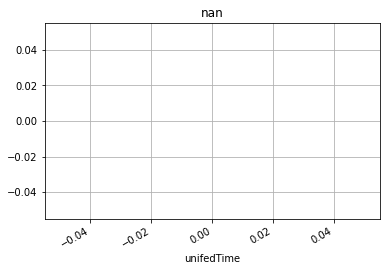

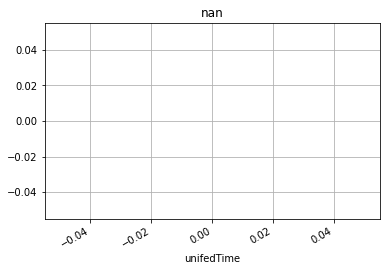

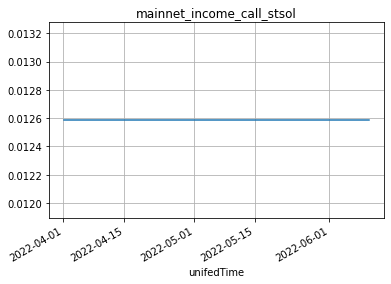

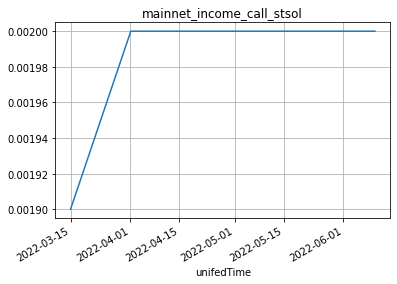

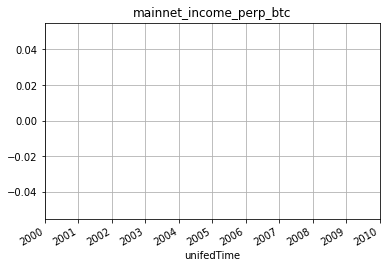

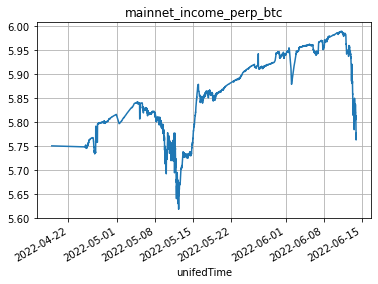

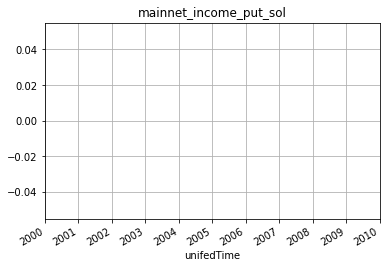

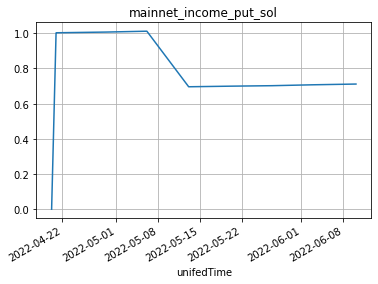

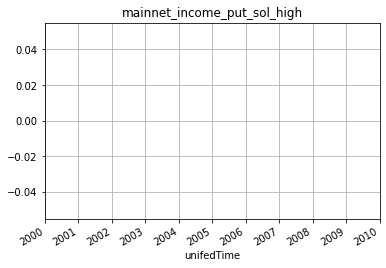

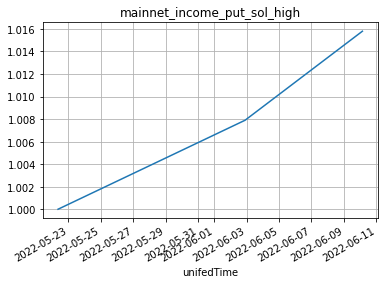

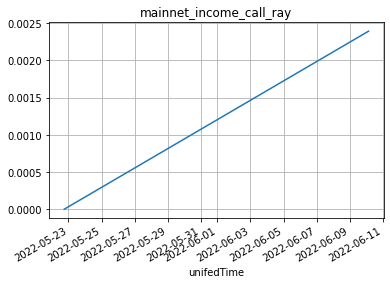

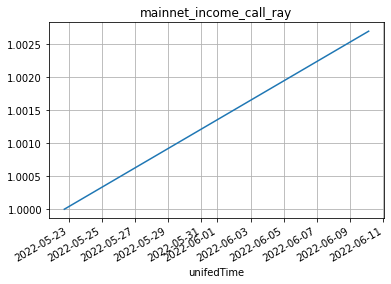

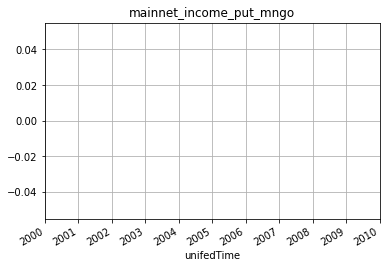

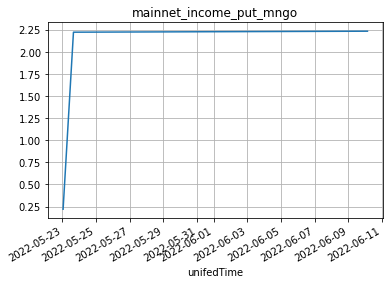

In [89]:
for g in z.GlobalID.unique():
    plt.figure()
    temp = z.loc[z.GlobalID==g]
    temp.set_index("unifedTime").USDPNLCumulAlpha.plot(grid=True, title=g)
    plt.figure()
    temp.set_index("unifedTime").TokenPositionPropagated.plot(grid=True, title=g)

In [92]:
z = [[1646427182000,"250.0000","0","0",250,0,0],[1647570032000,"251.5398","1.5398","1.5398",251.5398,1.5398,1.5398],[1648177215000,"252.7987","1.2589","2.7987",252.7987,1.2589,2.7987],[1648787900000,"0.0000","0","3.9047",0,0,3.9047],[1648787900000,"253.9047","1.1060","3.9047",253.9047,1.106,3.9047],[1649104628000,"2900000.0000","0","3.9047",2900000,0,3.9047],[1649385638000,"2900000.0000","0.0000","3.9047",2900000,0,3.9047],[1649991892000,"2909161.0347","0.0000","9164.9394",2909161.0347,0,9164.9394],[1649991892000,"2909161.0347","9161.0347","9164.9394",2909161.0347,9161.0347,9164.9394],[1650602035000,"2916925.1505","0.0000","16929.0552",2916925.1505,0,16929.0552],[1650602035000,"2916925.1505","7764.1158","16929.0552",2916925.1505,7764.1158,16929.0552],[1650602035000,"841400.6300","0","16929.0552",841400.63,0,16929.0552],[1651207756000,"844700.8833","0.0000","20229.3085",844700.8833,0,20229.3085],[1651207756000,"844700.8833","3300.2533","20229.3085",844700.8833,3300.2533,20229.3085],[1651807782000,"848871.1760","0.0000","24399.6012",848871.176,0,24399.601199999997],[1651807782000,"848871.1760","4170.2927","24399.6012",848871.176,4170.2927,24399.601199999997],[1651807782000,"0.0000","0","24399.6012",0,0,24399.601199999997],[1652412410000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1652412410000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1653021156000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1653021156000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1653617760000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1653617760000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654206295000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654206295000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654831234000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654831234000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654831234000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654831234000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654831234000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997],[1654831234000,"0.0000","0.0000","24399.6012",0,0,24399.601199999997]]

In [115]:
zz = pd.DataFrame(z, columns=["time", "tokenpos", "tokenpnl", "tokenpnlcum", "usdpos", "usdpnl", "usdpnlcum"])

In [116]:
zz["time"] = pd.to_datetime(zz.time, unit='ms')

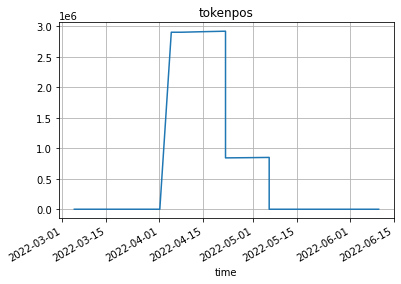

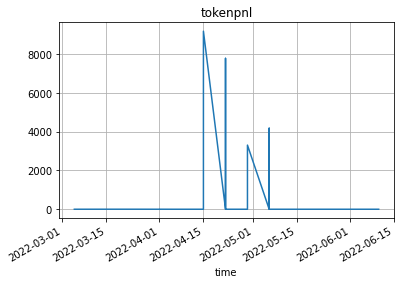

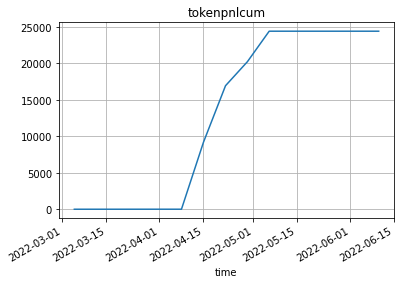

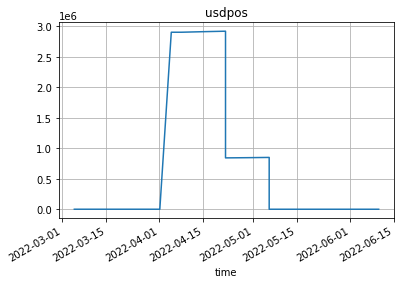

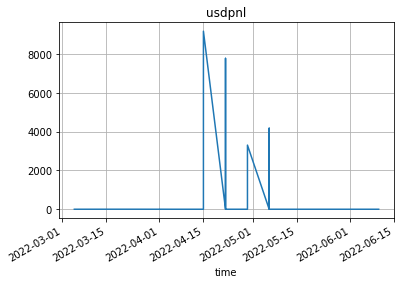

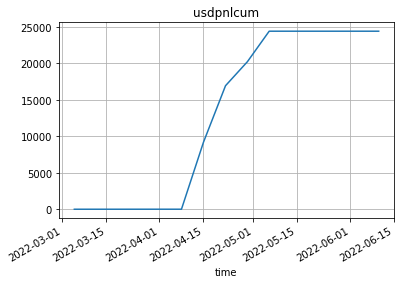

In [120]:
for col in zz.columns[1:]:
    plt.figure()
    zz.set_index("time")[col].astype('float').plot(grid=True)
    plt.title(col)

In [132]:
z = pd.read_csv("data-1655356269820.csv")

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_56822/1159575582.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  z = pd.read_csv("data-1655356269820.csv")


In [136]:
for x in z.GlobalID.unique():
    print(x)
    print(z.loc[z.GlobalID==x].shape)

mainnet_income_perp_btc
(1180, 9)
mainnet_income_put_eth
(1, 9)
mainnet_income_put_luna
(3162, 9)
mainnet_income_put_btc
(1, 9)
mainnet_income_put_mngo
(5, 9)
mainnet_income_put_sol
(25, 9)
mainnet_income_put_sol_high
(4, 9)
mainnet_income_call_sol
(4313, 9)
mainnet_income_call_btc
(4243, 9)
mainnet_income_call_eth
(4245, 9)
mainnet_income_call_marinade
(4244, 9)
mainnet_income_call_socean
(3847, 9)
mainnet_income_call_srm
(3650, 9)
mainnet_income_call_sbr
(3824, 9)
mainnet_income_call_luna
(3821, 9)
mainnet_income_call_mngo
(3824, 9)
mainnet_income_call_ftt
(3823, 9)
mainnet_income_call_ray
(3689, 9)
mainnet_income_put_tsUSDC
(2980, 9)
mainnet_income_call_sol_high
(2663, 9)
mainnet_income_call_step
(2258, 9)
mainnet_income_call_stsol
(2182, 9)
mainnet_income_call_avax
(1979, 9)
mainnet_income_put_pai
(1175, 9)
mainnet_income_put_uxd
(1122, 9)
mainnet_income_call_samo
(1007, 9)
mainnet_income_call_btc_step_circuits
(758, 9)
mainnet_income_call_sol_parrot_circuits
(758, 9)
mainnet_incom